# **First Assignment - Mattia Palmiotto**

**MSc course in Artificial Intelligence**

In [1]:
# I first clone the course repository
!rm -rf AI_USI_MA
!git clone https://github.com/UmbertoJr/AI_USI_MA.git

Cloning into 'AI_USI_MA'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 398 (delta 53), reused 99 (delta 25), pack-reused 265
Receiving objects: 100% (398/398), 13.97 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [2]:
# I prepare the environment by importing the necessary libraries.

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from time import time as t
import matplotlib.pyplot as plt
import random
import math

from AI_USI_MA.IO_manager.io_tsp import TSP_Instance_Creator
from AI_USI_MA.solvers.local_search import TwoOpt
from AI_USI_MA.solvers.TSP_solver import Solver_TSP
from AI_USI_MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
from AI_USI_MA.solvers.constructive_algorithms import compute_length
from AI_USI_MA.solvers.two_opt_with_candidate import twoOpt_with_cl

**Implement Iterated Local Search (ILS)**

The Iterated Local Search (ILS) is a metaheuristic that seeks to improve the quality of solutions by repeatedly applying a local search and introducing slight modifications (perturbations) to escape from local optima. This approach proves beneficial, especially for combinatorial problems like the Traveling Salesman Problem (TSP).

Develop the ILS algorithm using the three acceptance criteria as described in the paper *Iterated Local Search: Framework and Applications:*

*   **Better**
*   **Random Walk (RW)**
*   **Large Step Markov Chain (LSMC)**

# Double Bridge

First, I need to write the code to perform the double bridge perturbation.

In the chunk below, I define the class `DoubleBridge`, which consists of two methods:

*   The function `perturb_solution` takes as input the array of the (current) solution, its cost and its distances matrix. It returns the array of a new, perturbed solution and its cost.
To do so, the function randomly samples 4 nodes and creates a new solution by switching the connections of such nodes. Afterwards, it makes use of the function `difference_cost` to obtain the difference in cost between the perturbed solution and the original one. Eventually, it adds such a value to the cost taken as input in order to obtain the cost of the perturbed solution.

*   The function `difference_cost` takes as input the unperturbed solution, its distances matrix and the sampled nodes. It returns the difference in cost between the perturbed solution and the original one. To do so, it first calculates the costs of the new connections in the perturbed solution and the costs of the deleted connections in the original solution; afterwards, it subtracts the latter to the first value.

In [3]:
class DoubleBridge:

  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):

    new_costs = ( matrix[solution[a],solution[c+1]] +
                  matrix[solution[d],solution[b+1]] +
                  matrix[solution[c],solution[a+1]] +
                  matrix[solution[b],solution[d+1]] )

    previous_costs = ( matrix[solution[a],solution[a+1]] +
                       matrix[solution[b],solution[b+1]] +
                       matrix[solution[c],solution[c+1]] +
                       matrix[solution[d],solution[d+1]] )

    diff_costs = new_costs - previous_costs

    return diff_costs

  @staticmethod
  def perturb_solution(solution, actual_cost, matrix):

    a, b, c, d = random.sample(range(len(solution)), 4)
    a, b, c, d = sorted([a, b, c, d])

    perturbed_solution = ( np.concatenate( (solution[:a], solution[c+1:d],
                                            solution[b+1:c], solution[a+1:b],
                                            solution[d+1:] ) )
                      )
    diff_cost = DoubleBridge.difference_cost(solution,a,b,c,d,matrix)

    perturbed_cost = actual_cost + diff_cost

    return perturbed_solution, perturbed_cost

# The three acceptance criteria

Now I define the three functions to implement the three different acceptance criteria.

The three functions take as input a solution, its cost and the corresponding distances matrix. They have in common a similar code at the beginning. The function `my_local_search` is called to find the best solution in neighborhood of the input solution. Afterwards, there is a `while` cycle; in its first lines of the cycle, the current solution is perturbed using *Double Bridge* and we look for the best solution in its neighborhood. If the new solution has lower cost than the current best solution, it is taken as best solution; if the new solution meets the acceptance criteria, it is taken as current solution.

*   **Better**: Accepts a new solution only if it is better than the current solution in terms of
the objective function.
*   **Random Walk (RW)**: Accepts any new solution irrespective of its quality. This encourages exploration of the search space.
*   **Large Step Markov Chain (LSMC)**: Accepts new solutions based on a probabilistic rule that takes in consideration the difference between the new solution and the current
solution. Typically, the probability decreases as the quality difference increases.

The last method relies on the function `acceptance_criterion` which returns 1 if the new solution is accepted, i.e. if it has a smaller cost w.r.t. the current best solution or if has an higher cost and the random value generated by a standard uniform random variable is less than or equal to the probability of acceptance, which depends also the temperature. Otherwise, the function returns 0.

The `yield` statement serves as a generator: it permits the algorithm to produce solutions in phases, thus allowing exploration of a plethora of potential solutions without exhaustive execution.

The solver stops running only when the time limit is reached.

In [4]:
def my_local_search(solution, cost_sol, dist_matrix):
  new_solution, new_cost = solution, cost_sol
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data
    if ending_cond == True:
      break
  return new_solution, new_cost

class ILS_Better:

  @staticmethod
  def solve(solution, actual_cost, matrix):

    global cost_sol_better
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_better.append(new_cost)
    ls_calls = 1

    solution, actual_cost = new_sol, new_cost

    while True:

      # implement perturbation

      perturbed_sol, pert_cost = DoubleBridge.perturb_solution(solution,actual_cost,matrix)
      new_sol, new_cost = my_local_search(perturbed_sol, pert_cost, matrix)
      cost_sol_better.append(new_cost)

      # implement acceptance criterion

      if new_cost < best_cost:
        best_sol, best_cost = new_sol, new_cost
        solution, actual_cost = new_sol, new_cost

      ls_calls += 1

      yield best_sol, best_cost, ls_calls, False

class ILS_RW:

  @staticmethod
  def solve(solution, actual_cost, matrix):

    global cost_sol_RW

    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_RW.append(new_cost)
    ls_calls = 1

    solution, actual_cost = new_sol, new_cost

    while True:

      # implement perturbation

      perturbed_sol, pert_cost = DoubleBridge.perturb_solution(solution,actual_cost,matrix)
      new_sol, new_cost = my_local_search(perturbed_sol, pert_cost, matrix)
      cost_sol_RW.append(new_cost)

      if new_cost < best_cost:
        best_sol, best_cost = new_sol, new_cost

      # implement acceptance criterion

      solution, actual_cost = new_sol, new_cost

      ls_calls += 1

      yield best_sol, best_cost, ls_calls, False

class ILS_LSMC:

  @staticmethod
  def acceptance_criterion(best_cost, new_cost, temperature):

    if new_cost < best_cost:
      result = 1

    else:
      prob = math.exp((new_cost-best_cost)/temperature)
      u = random.uniform(0,1)
      if prob > u:
        result = 1
      else:
        result = 0

    return result

  @staticmethod
  def solve(solution, actual_cost, matrix):

    global cost_sol_LSMC

    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_LSMC.append(new_cost)
    ls_calls = 1

    solution, actual_cost = new_sol, new_cost

    T = 100

    while True:

      # implement perturbation

      perturbed_sol, pert_cost = DoubleBridge.perturb_solution(solution,actual_cost,matrix)
      new_sol, new_cost = my_local_search(perturbed_sol, pert_cost, matrix)
      cost_sol_RW.append(new_cost)

      if new_cost < best_cost:
        best_sol, best_cost = new_sol, new_cost

      # implement acceptance criterion

      if ILS_LSMC.acceptance_criterion(best_cost, new_cost, T):
        solution, actual_cost = new_sol, new_cost

      T = 0.9*T
      ls_calls += 1

      yield best_sol, best_cost, ls_calls, False

# The instances

In this assignment, we will be focusing on solving the TSP using ILS for three benchmark instances:

1.   **d198**: A standard instance known as 'd198.tsp' in TSP literature.
2.   **pr439**: Another well-studied instance that will test the efficiency and efficacy of our ILS approach.
3.   **u1060**: A relatively larger instance, serving as a comprehensive test for the scalability of our method.
   
Let's begin by loading and inspecting the three instances.

name: d198
nPoints: 198
best_sol: 15780.0


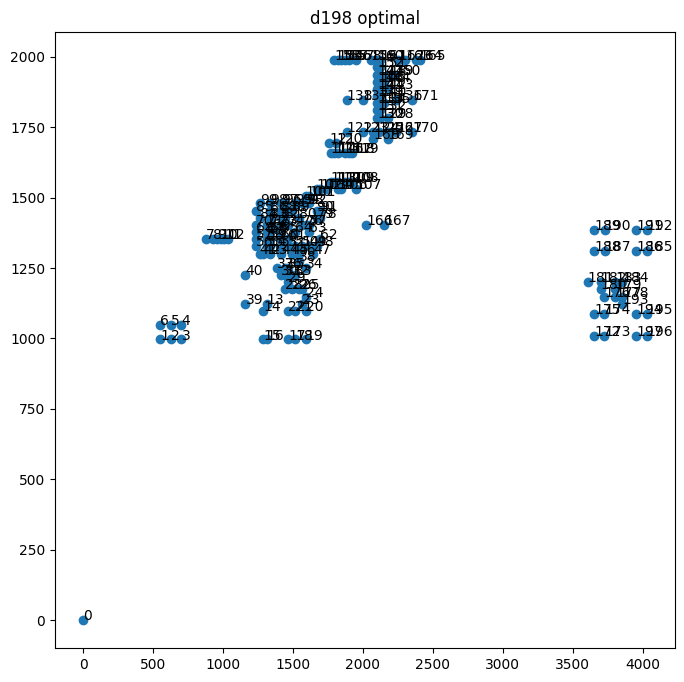

name: pr439
nPoints: 439
best_sol: 107217.0


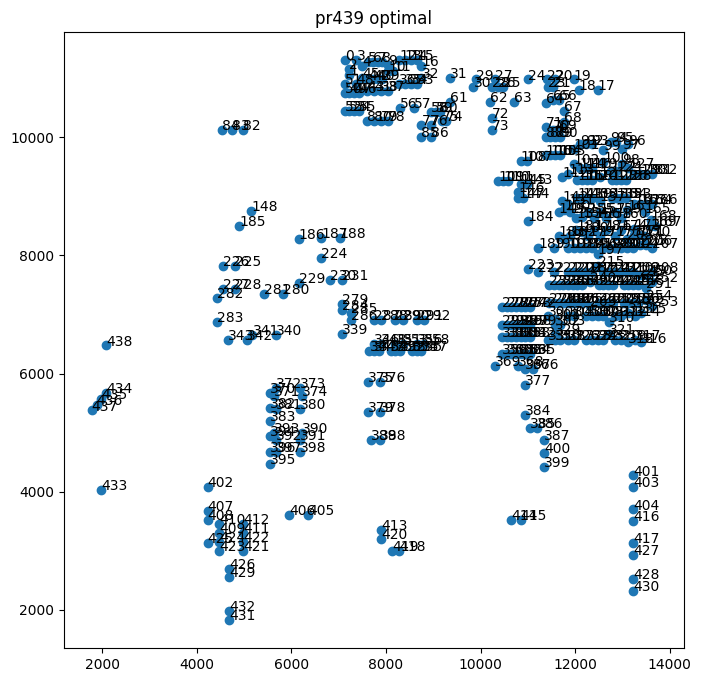

name: u1060
nPoints: 1060
best_sol: 224094.0


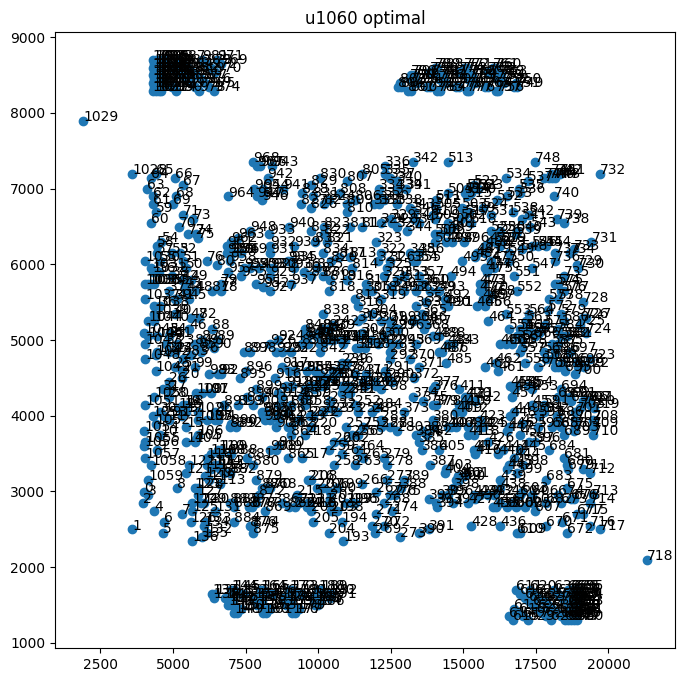

In [5]:
names_instances = ["d198.tsp", "pr439.tsp", "u1060.tsp"]
ic = [TSP_Instance_Creator("standard", name) for name in names_instances]

for i in range(3):
  ic[i].print_info()
  ic[i].plot_data()

# Applying the solvers to the instances

In [9]:
seeds= [0, 123, 333]
time_to_solve = 1  # I intentionally keep time_to_solve = 1 because it takes
                   # too much time. Even by setting it equal to 1, only the seed
                   # 0 requires:
                   # - around 10 seconds for "d198.tsp"
                   # - around 1 minute for "pr439.tsp"
                   # - around 13 minutes for "u1060.tsp"
                   # Overall, it takes 45/50 minutes. Setting time_to_solve
                   # smaller than 1 does not reduce this running time.

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

names_instances = ["d198.tsp", "pr439.tsp", "u1060.tsp"]

initializers = ["random"]
init_functions = [Random_Initializer.random_method]

improvements = ["ILS-better","ILS-RW","ILS-LSMC"]
improve_functions = [ILS_Better.solve, ILS_RW.solve, ILS_LSMC.solve]

results = []
index = []
samples = {name: {improve: {seed: [] for seed in seeds} for improve in improvements} for name in names_instances}

for s_ in seeds:
  collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve][s_] = np.round(np.abs(np.array(collectors[j]) - instance.best_sol)/instance.best_sol * 100, 2)
        if j == 0:
          cost_sol_better = []
        elif j == 1:
          cost_sol_RW = []
        else:
          cost_sol_LSMC = []

index = pd.MultiIndex.from_tuples(index, names=['problem','optimal length', 'method', 'seed'])

pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls Local Search"])

,,,,tour length,gap,time to solve,calls Local Search
problem,optimal length,method,seed,,,,
d198.tsp,15780.0,"initialized with random, improved with ILS-better",0,16249.0,2.97,4.420,2
pr439.tsp,107217.0,"initialized with random, improved with ILS-better",0,113094.0,5.48,14.772,2
u1060.tsp,224094.0,"initialized with random, improved with ILS-better",0,247152.0,10.29,197.781,2
d198.tsp,15780.0,"initialized with random, improved with ILS-RW",0,16188.0,2.59,3.435,2
pr439.tsp,107217.0,"initialized with random, improved with ILS-RW",0,116598.0,8.75,22.226,2
u1060.tsp,224094.0,"initialized with random, improved with ILS-RW",0,248042.0,10.69,153.222,2
d198.tsp,15780.0,"initialized with random, improved with ILS-LSMC",0,16052.0,1.72,2.449,2
pr439.tsp,107217.0,"initialized with random, improved with ILS-LSMC",0,120284.0,12.19,15.008,2
u1060.tsp,224094.0,"initialized with random, improved with ILS-LSMC",0,245390.0,9.50,135.661,2


# Report

The local search calls are always 2 for each instance, seed and method.

The best result achieved during the search concerns the smallest instance `d198.tsp`. The **LSMC** method results in a gap of **1.72** with seed=0.

The gap between the approximated solution and the optimal one seems to depend a lot on the instance.

The instance `d198.tsp`, with the least number of points, is always the one for which the lowest gap is reached, oscillating between 1.72 and 5.30.

The instance `pr439.tsp` has a gap oscillating between 5.48 and 12.19 and is lower than the gap of`u1060.tsp` five times out of nine.

The gap of `u1060.tsp` oscillates between 9.38 and 10.81.

I did expect that the gap of the instance with the least size would have been smaller, since it has a minor search space. For the same reason, I would also have expected that the medium-size instance would have had a smaller gap than the largest instance more than five times.

In the following comparisons I make use of the sign `<` to indicate that the left-side method resulted in a lower gap than the right-side method.

I see that, for the instance `d198.tsp`:
*   Seed 0:   LSMC < RW < Better
*   Seed 123: Better < RW = LSMC
*   Seed 333: Better = RW = LSMC

I see that, for the instance `pr439.tsp`:
*   Seed 0:   Better < RW < LSMC
*   Seed 123: RW < Better < LSMC
*   Seed 333: Better < LSMC < RW

I see that, for the instance `u1060.tsp`:
*   Seed 0:   LSMC < Better < RW
*   Seed 123: Better = LSMC < RW
*   Seed 333: Better < LSMC < RW

We observe that:
1.	The **Better** method resulted in the lowest gap six times out of nine, the **RW** method two times and the **LSMC** method three times. This would suggest that the Better method is usually more reliable than the other methods.
2.	The **Random Walk** method resulted in the poorest performance in all the seeds of the largest instances, suggesting that maybe it does not perform very well on large instances.
3.	It is possible that, for a given instance and seed, two or all three methods return the same solution, or different solutions with the same gap.
